<a href="https://colab.research.google.com/github/present42/PyTorchPractice/blob/main/Following_Jax_tutorial_(7)_Parallel_Evaluation_in_Jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [4]:
import numpy as np
import jax.numpy as jnp

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x) - 1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [5]:
n_devices = jax.local_device_count()

xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34],
       [35, 36, 37, 38, 39]])

In [6]:
ws

array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])

In [7]:
jax.vmap(convolve)(xs, ws)

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)

In [10]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

Array([[   78.,   138.,   198.],
       [ 1188.,  1383.,  1578.],
       [ 3648.,  3978.,  4308.],
       [ 7458.,  7923.,  8388.],
       [12618., 13218., 13818.],
       [19128., 19863., 20598.],
       [26988., 27858., 28728.],
       [36198., 37203., 38208.]], dtype=float32)

## Specifying `in_axes`

In [11]:
# inaxes specifies whether an argument to the parallelized function should be broadcasted (None)
# or whether it should be split along a given axis
jax.pmap(convolve, in_axes=(0, None))(xs, w)

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)

When calling the transformed function, the size of the specified axis in arguments must not exceed the number of devices available to the host.

In [14]:
def normalized_convolution(x, w):
  output = []
  for i in range(1, len(x) - 1):
    output.append(jnp.dot(x[i-1:i+2], w))
  output = jnp.array(output)
  return output / jax.lax.psum(output, axis_name='p')

In [15]:
jax.pmap(normalized_convolution, axis_name='p')(xs, ws)

Array([[0.00816024, 0.01408451, 0.019437  ],
       [0.04154303, 0.04577465, 0.04959785],
       [0.07492582, 0.07746479, 0.07975871],
       [0.10830861, 0.10915492, 0.10991956],
       [0.14169139, 0.14084506, 0.14008042],
       [0.17507419, 0.17253521, 0.17024128],
       [0.20845698, 0.20422535, 0.20040214],
       [0.24183977, 0.23591548, 0.23056298]], dtype=float32)

Note that `jax.vmap` also supports `axis_name` which allows `jax.lax.p*` operations to be used in the vectorization context in the same way they would be used in a `jax.pmap`.

In [16]:
jax.vmap(normalized_convolution, axis_name='p')(xs, ws)

Array([[0.00816024, 0.01408451, 0.019437  ],
       [0.04154303, 0.04577465, 0.04959785],
       [0.07492582, 0.07746479, 0.07975871],
       [0.10830861, 0.10915492, 0.10991956],
       [0.14169139, 0.14084506, 0.14008042],
       [0.17507419, 0.17253521, 0.17024128],
       [0.20845698, 0.20422535, 0.20040214],
       [0.24183977, 0.23591548, 0.23056298]], dtype=float32)

## Nesting `jax.pmap` and `jax.vmap`

Example of a regression training loop with data parallelism, where each batch is split into sub-batches wheich are evaluated on separate devices.

In [ ]:
jax.vmap(jax.pmap(f, axis_name='i'), axis_name='j')

In [22]:
from typing import NamedTuple
import functools

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray

def init(rng) -> Params:
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)

def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
  pred = params.weight * xs + params.bias
  return jnp.mean((pred - ys) ** 2)

LEARNING_RATE = 0.005

@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> tuple[Params, jnp.ndarray]:
  loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

  # aggregated gradient
  grads = jax.lax.pmean(grads, axis_name='num_devices')

  # aggregated loss
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  new_params = jax.tree_map(
      lambda param, g: param - LEARNING_RATE * g,
      params,
      grads
  )

  return new_params, loss

In [30]:
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

params = init(jax.random.key(123))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

In [31]:
replicated_params

Params(weight=Array([-0.12120727, -0.12120727, -0.12120727, -0.12120727, -0.12120727,
       -0.12120727, -0.12120727, -0.12120727], dtype=float32), bias=Array([-1.7094023, -1.7094023, -1.7094023, -1.7094023, -1.7094023,
       -1.7094023, -1.7094023, -1.7094023], dtype=float32))

In [25]:
def split(arr):
  return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

x_split = split(xs)
y_split = split(ys)

type(x_split)

numpy.ndarray

In [27]:
def type_after_update(name, obj):
  print(f"after first `update()`, `{name}` is a", type(obj))

for i in range(1000):
  replicated_params, loss = update(replicated_params, x_split, y_split)

  if i == 0:
    type_after_update('replicated_params.weight', replicated_params.weight)
    type_after_update('loss', loss)
    type_after_update('x_split', x_split)

  if i % 100 == 0:
    print(f"Step {i:3d}, loss {loss[0]:.3f}")

params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))


after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `loss` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `x_split` is a <class 'numpy.ndarray'>
Step   0, loss 0.263
Step 100, loss 0.263
Step 200, loss 0.263
Step 300, loss 0.263
Step 400, loss 0.263
Step 500, loss 0.263
Step 600, loss 0.263
Step 700, loss 0.263
Step 800, loss 0.263
Step 900, loss 0.263


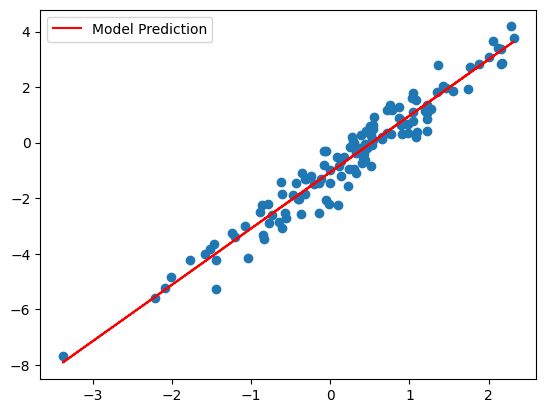

In [28]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend()
plt.show()

In [32]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
import os